# Electrical Submersible Pump (ESP) Design
**Objective:** Select an appropriate ESP pump stage and calculate the required number of stages to lift fluid to surface.

**Author:** Ade Anggi Naluriawan Santoso

**The Logic:**
An ESP is a multi-stage centrifugal pump.
1.  **Head (H):** The height a pump can lift fluid.
2.  **Rate (Q):** The volume of fluid moved.

**Total Dynamic Head (TDH):**
The total energy the pump must supply is the sum of:
1.  **Net Lift:** Distance from fluid level to surface.
2.  **Friction:** Loss in the tubing.
3.  **Surface Pressure:** Head required to overcome wellhead pressure.

$$TDH = H_{surf} + H_{lift} + H_{friction}$$

In this notebook, we will:
1.  Digitize a manufacturer's Pump Curve.
2.  Calculate the TDH required for our well.
3.  Determine the number of stages needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Digitizing the Pump Curve
Real ESP design uses catalogs (Reda, Schlumberger, Baker). A single "Stage" of a pump has a specific performance curve.

Let's simulate a pump curve for a **"DN-1750"** pump (Design rate ~1750 bpd).
* **Best Efficiency Point (BEP):** 1750 bpd @ 25 ft/stage.
* **Max Flow (Runout):** 2500 bpd.
* **Shut-in Head:** 32 ft.

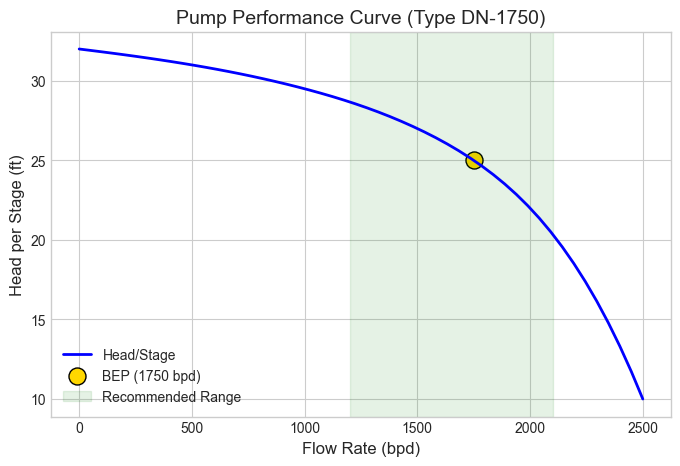

In [2]:
# --- SIMULATED PUMP CURVE DATA (Per Stage) ---
# Rate (bpd) vs Head (ft)
q_curve_data = [0, 500, 1000, 1500, 1750, 2000, 2500]
h_curve_data = [32, 31, 29.5, 27, 25, 22, 10]

# Interpolation Function
pump_curve = interp1d(q_curve_data, h_curve_data, kind='cubic')

# Plot the Curve
q_range = np.linspace(0, 2500, 50)
h_range = pump_curve(q_range)

plt.figure(figsize=(8, 5))
plt.plot(q_range, h_range, 'b-', linewidth=2, label='Head/Stage')
plt.scatter([1750], [25], color='gold', s=150, edgecolors='black', label='BEP (1750 bpd)')

# Recommended Operating Range (ROR) - usually 70-120% of BEP
plt.axvspan(1200, 2100, color='green', alpha=0.1, label='Recommended Range')

plt.title("Pump Performance Curve (Type DN-1750)", fontsize=14)
plt.xlabel("Flow Rate (bpd)", fontsize=12)
plt.ylabel("Head per Stage (ft)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 2. Calculating Required Total Dynamic Head (TDH)
We need to lift **2000 bpd** of fluid.

**Well Parameters:**
* **Pump Depth:** 6000 ft
* **Producing Fluid Level:** 5000 ft (This means there is 1000 ft of liquid above the pump helping us).
* **Wellhead Pressure:** 150 psi
* **Tubing:** 2-7/8" (ID = 2.441")
* **Fluid SG:** 1.0 (Water)

In [3]:
# --- INPUTS ---
target_rate = 2000 # bpd
pump_depth = 6000  # ft
fluid_level = 5000 # ft (Depth to fluid surface from wellhead)
p_wh = 150         # psi
sg = 1.0           # Specific Gravity

# 1. Net Vertical Lift
# The pump must lift fluid from the dynamic level (5000 ft) to surface (0 ft).
# (Note: Even though pump is at 6000, the 1000ft column above it provides "intake pressure" helping it).
h_lift = fluid_level

# 2. Surface Pressure Head
# Convert psi to feet: Head = psi * 2.31 / SG
h_surf = p_wh * 2.31 / sg

# 3. Friction Head
# Use Hazen-Williams or simplified Darcy for water/brine
# Friction Loss factor (ft/1000ft) for 2000 bpd in 2.875" tubing approx 45 ft/1000ft
friction_factor = 45 # ft/1000ft (Approximation)
h_friction = friction_factor * (pump_depth / 1000)

# Total TDH
TDH = h_lift + h_surf + h_friction

print(f"--- TDH Calculation at {target_rate} bpd ---")
print(f"1. Net Lift:      {h_lift:.0f} ft")
print(f"2. Surface Head:  {h_surf:.0f} ft")
print(f"3. Friction Head: {h_friction:.0f} ft")
print(f"-----------------------------")
print(f"TOTAL DYNAMIC HEAD: {TDH:.0f} ft")

--- TDH Calculation at 2000 bpd ---
1. Net Lift:      5000 ft
2. Surface Head:  346 ft
3. Friction Head: 270 ft
-----------------------------
TOTAL DYNAMIC HEAD: 5616 ft


## 3. Sizing the Pump (Stage Count)
Now we divide the **Total Required Head** by the **Head Per Stage** at the target rate.

$$N_{stages} = \frac{TDH}{Head_{stage}(Q)}$$

In [4]:
# 1. Get Head per Stage from our digitized curve
head_per_stage = pump_curve(target_rate)

# 2. Calculate Stages
n_stages_raw = TDH / head_per_stage
n_stages = int(np.ceil(n_stages_raw)) # Round up to nearest whole stage

print(f"Target Rate: {target_rate} bpd")
print(f"Head per Stage: {head_per_stage:.1f} ft")
print(f"Required Stages: {n_stages} stages")

# 3. Motor Power Estimation
# Hydraulic HP = Q * H * SG / 135,800 (if Q in bpd, H in ft)
# Brake HP = Hydraulic HP / Pump Efficiency
eff_pump = 0.70 # Assume 70% efficiency
eff_motor = 0.85 # Assume 85% motor efficiency

hhp = (target_rate * TDH * sg) / 135800
bhp = hhp / eff_pump
kVA = (bhp * 0.746) / eff_motor # Approximate kVA req

print(f"--- Power Requirements ---")
print(f"Hydraulic HP: {hhp:.1f} HP")
print(f"Motor Nameplate HP (approx): {bhp:.1f} HP")

Target Rate: 2000 bpd
Head per Stage: 22.0 ft
Required Stages: 256 stages
--- Power Requirements ---
Hydraulic HP: 82.7 HP
Motor Nameplate HP (approx): 118.2 HP


## 4. Visualization
Let's see the Operating Point on the Full Pump Curve (Curve * N_stages).

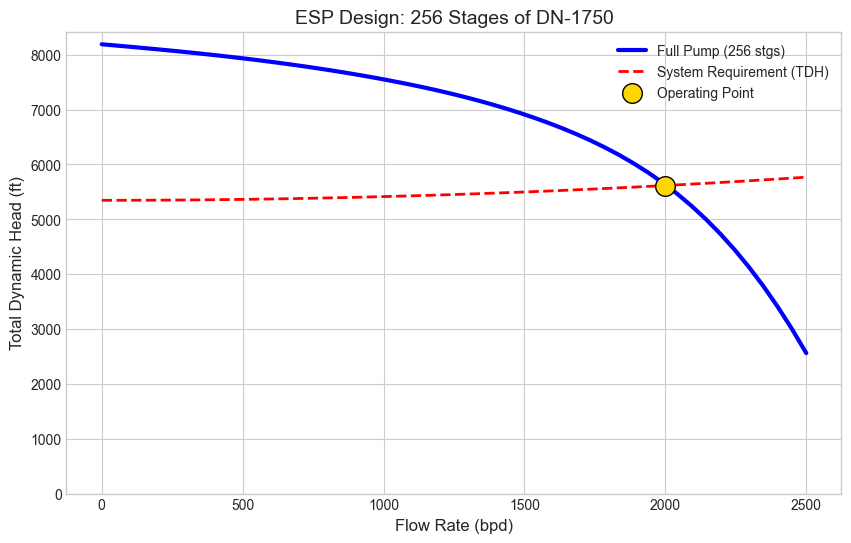

In [5]:
# Create the Full Pump Curve (Head * Stages)
h_full_pump = h_range * n_stages

plt.figure(figsize=(10, 6))

# Plot Pump Curve
plt.plot(q_range, h_full_pump, 'b-', linewidth=3, label=f'Full Pump ({n_stages} stgs)')

# Plot System Curve (TDH vs Rate)
# Note: TDH changes with rate because Friction changes with rate^2
system_curve_friction = [friction_factor * ((q/target_rate)**2) * (pump_depth/1000) for q in q_range]
system_tdh = [h_lift + h_surf + f for f in system_curve_friction]

plt.plot(q_range, system_tdh, 'r--', linewidth=2, label='System Requirement (TDH)')

# Plot Operating Point
plt.scatter(target_rate, TDH, color='gold', s=200, edgecolors='black', zorder=10, label='Operating Point')

plt.title(f"ESP Design: {n_stages} Stages of DN-1750", fontsize=14)
plt.xlabel("Flow Rate (bpd)", fontsize=12)
plt.ylabel("Total Dynamic Head (ft)", fontsize=12)
plt.ylim(0, TDH * 1.5)
plt.legend()
plt.grid(True)

plt.show()

## Summary
We selected a **1750-series pump**, ran it at **2000 bpd** (inside the green recommended range), and determined we need roughly **250-300 stages** (depending on your exact run).

**Next Step:**
We move to **Part V: Stimulation**.
covers **Matrix Acidizing**, calculating the max pressure we can pump acid without fracturing the rock.